This notebook compares the gene sets of the same cell (e.g. Hepatocytes) across different states. This is to check whether the states are mutually exclusive.

## Input section

In this section basic parameters can be set to for summary, the subsequent cells can be run in bulk.

### Variables to set

- directory
  - The directory of EcoTyper results to compare the state assignments across cell types in. This may be relative to the project parent directory which can be specified as `{parent}` or the project's results directory which can be specified as `{results}`.

In [1]:
directory = "{results}/drop_hepato_run1_50"

Other project directories (need not necessarily be edited)

In [2]:
# the parent directory of the EcoTyper project
parent = "/data/users/noahkleinschmidt/EcoTyper"

# script and results directories within the parent
scripts = f"{parent}/scripts"
results = f"{parent}/results"

if directory:
    directory = directory.format( parent = parent, results = results )
else:
    raise Exception( "Please specify a directory to search." )

Now import necessary packages

In [3]:
import eco_helper as eh
import qpcr._auxiliary.graphical as gx
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Analysis section

In this section we compare the cell state gene sets across different cell types for the same state.

In [4]:
# get the cell state collection for the cell types present in the directory
states = eh.core.CellStateCollection( directory )
genes = states.get_genes()

Now pair-wise compare the set overlap between the state genes within each cell type.

In [21]:
pairwise_comparisons = {}

for cell_type, sets in genes.items():

    sets = { state : i.index.values for state, i in sets.groupby("State") }
    states = list( sets.keys() )

    length = len( states )
    comparisons = np.full( ( length, length ), np.nan )
    
    combos = combinations( states, r = 2 )
    for a, b in combos:
       
        adx, bdx = states.index(a), states.index(b)
        a, b = sets[a], sets[b]
        a, b = set(a), set(b)

        comparison = eh.core.gene_sets.BaseOverlap( a, b )
        comparison = comparison.get( percent = True ).values
        
        comparisons[ adx, bdx ] = comparison
        comparisons[ bdx, adx ] = comparison

    pairwise_comparisons[ cell_type ] = pd.DataFrame( comparisons, index = states, columns = states )

Now visualize the overlaps between the gene sets of the same state between different cell types.

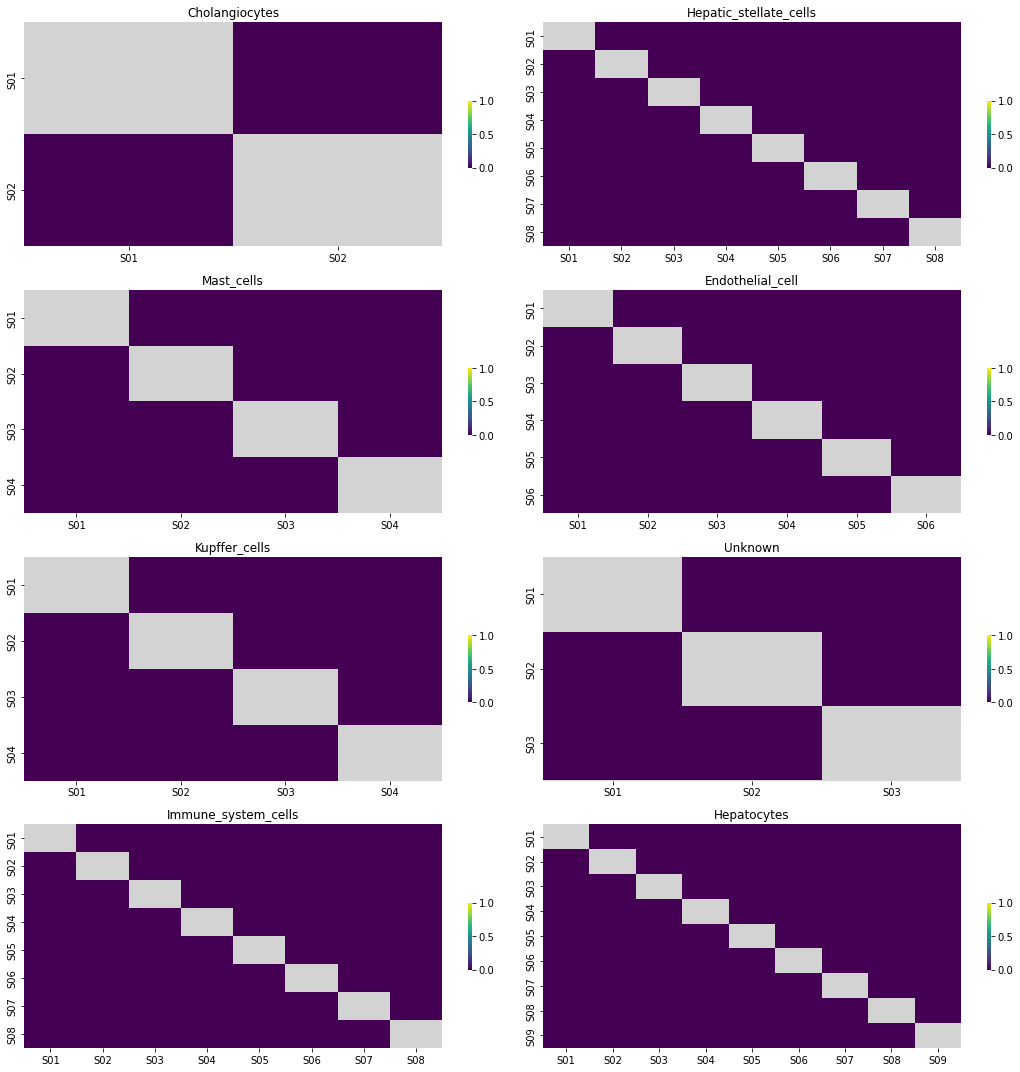

In [22]:
figsize = ( 15, 15 )
ncols, nrows = gx.make_layout_from_list( pairwise_comparisons.keys() )
fig, axs = plt.subplots( nrows = nrows, ncols = ncols, figsize = figsize )

for state, df, ax in zip( pairwise_comparisons.keys(), pairwise_comparisons.values(), axs.flat ):
    h = sns.heatmap( df, ax = ax, cbar = True, cmap = "viridis", vmin = 0, vmax = 1, cbar_kws = {"shrink" : 0.3} )
    h.set_facecolor( "lightgray" )
    ax.set_title( state )

fig.tight_layout()

In [23]:
# fig.savefig( "/data/users/noahkleinschmidt/EcoTyper/state_genes_within_cell_types.pdf" )